# Libraries and Functions

In [19]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Flatten, Dropout, Bidirectional, Embedding
from keras.initializers import Constant
from keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn.metrics import matthews_corrcoef
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import KFold
from keras.regularizers import l2, l1, l1_l2
import math
import matplotlib.pyplot as plt

In [20]:
# Function to parse data from a file
def parse_data(file_path):
    sequences, secondary_structures = [], []
    parsing_sequences = False
    with open(file_path, "r") as file:
        sequence = ""
        secondary_structure = ""
        for line in file:
            line = line.strip()
            if line == "<>" and not parsing_sequences:
                parsing_sequences = True
            elif line == "end" or line == "<end>":
                parsing_sequences = False
                sequences.append(sequence)
                secondary_structures.append(secondary_structure)
                sequence = ""
                secondary_structure = ""
            elif parsing_sequences and line == "<>":
                sequences.append(sequence)
                secondary_structures.append(secondary_structure)
                sequence = ""
                secondary_structure = ""
            elif parsing_sequences:
                parts = line.split()
                if len(parts) == 2:
                    amino_acid, sec_structure = parts
                    sequence += amino_acid
                    secondary_structure += sec_structure
    return sequences, secondary_structures

# Function to read aligned sequences from a file
def read_aligned_sequences(file_path):
    sequences = {}
    with open(file_path, "r") as file:
        sequence_number = None
        sequence = ""
        for line in file:
            line = line.strip()
            if line.startswith(">"):
                if sequence_number is not None:
                    sequences[sequence_number] = sequence
                sequence_number = int(line.split("_")[1])
                sequence = ""
            else:
                sequence += line
        if sequence_number is not None and sequence:
            sequences[sequence_number] = sequence
    return sequences

# Function to align structures with sequences
def align_structure(structures, sequences):
    aligned = {}
    for i in sequences.keys():
        align = []
        sequence = sequences[i]
        structure = structures[i-1]

        j = 0
        for char in sequence:
            if char == '-':
                align.append('-')
            else:
                align.append(structure[j])
                j += 1
        aligned[i] = align
    return aligned

def preprocess_data(aligned_sequences, aligned_sequence_structures, pssm, window_size):
    X = []
    y = []

    for seq_id, sequence in aligned_sequences.items():
        encoded_seq = encode_sequence_new(sequence, pssm)
        encoded_struct = encode_structure(aligned_sequence_structures[seq_id])

        # Pad the sequence symmetrically around each position
        pad_width = ((window_size // 2, window_size // 2), (0, 0))
        padded_seq = np.pad(encoded_seq, pad_width, mode='constant')

        for i in range(len(sequence)):
            # Extract window_size elements centered around the current position
            window_start = i
            window_end = i + window_size
            window = padded_seq[window_start:window_end]

            X.append(window)
            y.append(encoded_struct[i])

    # Remove instances with padding
    for i in range(len(y) - 1, -1, -1):
        if y[i] == 3:
            X.pop(i)
            y.pop(i)

    return np.array(X), np.array(y)

def encode_sequence_new(sequence, pssm):
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    num_amino_acids = len(amino_acids)
    encoded_seq = np.zeros((len(sequence), num_amino_acids), dtype=float)
    for i, aa in enumerate(sequence):
        if aa != "-":
        # for j, a in enumerate(amino_acids):
        #     encoded_seq[i, j] = pssm[i][a]
            encoded_seq[i, amino_acids.index(aa)] = pssm[i][aa]
    return encoded_seq

# Function to encode a structure
def encode_structure(structure):
    mapping = {'-': 3, '_': 0, 'e': 1, 'h': 2}
    return [mapping[char] for char in structure]
    

def calculate_accuracy(y_true, y_pred):

    if len(y_pred.shape) == 2:
        y_pred_labels = np.argmax(y_pred, axis=1)
    else:
        y_pred_labels = y_pred

    class_accuracies = {}
    for class_idx in range(3):
        class_pred_labels = y_pred_labels[y_true == class_idx]
        class_true_labels = y_true[y_true == class_idx]

        class_accuracy = np.sum(class_pred_labels == class_true_labels) / len(class_true_labels)

        class_names = {0: 'coil', 1: 'β-sheet', 2: 'α-helix'}
        class_accuracies[class_names[class_idx]] = class_accuracy

    for class_name, accuracy in class_accuracies.items():
        print(f"Accuracy for class {class_name}: {accuracy}")

    total_correct_predictions = np.sum(y_pred_labels == y_true)
    total_accuracy = total_correct_predictions / len(y_true)

    print("Total Accuracy:", total_accuracy)


def preprocess_data_2(predictions, window_size):
    sequence_length, num_classes = predictions.shape
    pad_width = ((window_size // 2, window_size // 2), (0, 0))

    # Define windowed_predictions shape considering all windows
    windowed_predictions = np.empty((sequence_length, window_size, num_classes))

    # Pad predictions
    padded_predictions = np.pad(predictions, pad_width, mode='constant')

    # Collect windows into a temporary list (optional)
    windows = []
    for j in range(len(padded_predictions) - window_size + 1):
        window_start = j
        window_end = j + window_size
        window = padded_predictions[window_start:window_end]
        windows.append(window)

    # Convert windows list to NumPy array and assign to windowed_predictions
    windowed_predictions = np.array(windows)

    return windowed_predictions

def add_spacers(X_train, processed_predictions):
    existing_shape = processed_predictions.shape

    # Create a new array with the desired shape, with the 4th dimension having zeros
    new_shape = existing_shape[:-1] + (1,)
    new_predictions = np.concatenate((processed_predictions, np.zeros(new_shape)), axis=-1)

    for i, sample in enumerate(X_train):

        # print(sample)
        # print(new_predictions[network_idx, i])

        indicies = np.where(sample[:, -1] == 1)
        new_predictions[i, indicies, 3] = 1

        # if sample[-1] == 1:
        #     new_predictions[network_idx, i, :, -1] = 1

    return new_predictions

def calculate_pssm(aligned_sequences):
    pssm = {}
    sequence_length = len(list(aligned_sequences.values())[0])
    total_sequences = len(aligned_sequences)

    # Initialize counts for each position
    for i in range(sequence_length):
        pssm[i] = {'A': 0, 'C': 0, 'D': 0, 'E': 0, 'F': 0, 'G': 0, 'H': 0, 'I': 0, 'K': 0, 'L': 0,
                   'M': 0, 'N': 0, 'P': 0, 'Q': 0, 'R': 0, 'S': 0, 'T': 0, 'V': 0, 'W': 0, 'Y': 0, '-': 0}

    # Count occurrences of each amino acid at each position
    for sequence in aligned_sequences.values():
        for i, aa in enumerate(sequence):
            if aa != "-":
                pssm[i][aa] += 1
                
    # Normalize counts to frequencies and calculate background frequencies
    background_frequencies = {aa: 0 for aa in pssm[0].keys()}
    for i in range(sequence_length):
        total_count = sum(pssm[i].values())
        for aa in pssm[i]:
            if total_count != 0:
                pssm[i][aa] /= total_count
            background_frequencies[aa] += pssm[i][aa] / total_sequences

    # Calculate log-odds scores
    for i in range(sequence_length):
        for aa in pssm[i]:
            if background_frequencies[aa] != 0:
                ratio = pssm[i][aa] / background_frequencies[aa]
                if ratio != 0:
                    pssm[i][aa] = math.log2(ratio)

    return pssm

def create_windows(sequences, window_size):
    num_samples, num_features = sequences.shape
    padded_seq = np.zeros((num_samples, window_size, num_features))
    pad_size = window_size // 2

    for i in range(num_samples):
        start_index = max(0, i - pad_size)
        end_index = min(num_samples, i + pad_size + 1)
        
        # Calculate the indices for the windowed data
        window_start = pad_size - (i - start_index)
        window_end = window_start + (end_index - start_index)
        
        # Copy the data into the padded array
        padded_seq[i, window_start:window_end, :] = sequences[start_index:end_index, :]
    
    return padded_seq

def calculate_correlation_coefficients(y_test, test_result):
    class_names = {0: 'coil', 1: 'β-sheet', 2: 'α-helix'}
    correlation_coefficients = {}
    for class_idx in range(3):
        actual_labels = (y_test == class_idx).astype(int)
        predicted_labels = (test_result == class_idx).astype(int)
        correlation_coefficient = matthews_corrcoef(actual_labels, predicted_labels)
        correlation_coefficients[class_names[class_idx]] = correlation_coefficient

    # Print correlation coefficients
    for class_name, correlation_coefficient in correlation_coefficients.items():
        print(f"MCC for class {class_name}: {correlation_coefficient}")

def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


# Data processing
Training and test files are preprocessed into different window sizes and profiled using a position-specific score matrices (pssm)

In [21]:
window_size_1 = 13
window_size_2 = 17
train_path = 'Q_and_s_data/protein-secondary-structure.train.txt'

# Preprocess training data
train_sequences, train_structures = parse_data(train_path)
aligned_sequences = read_aligned_sequences("Fasta_and_msa/training_msa.txt")
aligned_sequence_structures = align_structure(train_structures, aligned_sequences)
pssm_train = calculate_pssm(aligned_sequences)
X_train, y_train = preprocess_data(aligned_sequences, aligned_sequence_structures, pssm_train, window_size_1)
X_train_17, y_train_17 = preprocess_data(aligned_sequences, aligned_sequence_structures, pssm_train, window_size_2)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

test_path = 'Q_and_s_data/protein-secondary-structure.test.txt'

test_sequences, test_structures = parse_data(test_path)
test_aligned_sequences = read_aligned_sequences("Fasta_and_msa/test_msa.txt")
test_aligned_sequence_structures = align_structure(test_structures, test_aligned_sequences)
pssm_test = calculate_pssm(test_aligned_sequences)
X_test, y_test = preprocess_data(test_aligned_sequences, test_aligned_sequence_structures, pssm_test, window_size_1)
X_test_17, y_test_17 = preprocess_data(test_aligned_sequences, test_aligned_sequence_structures, pssm_test, window_size_2)

In [22]:
middle = X_train.shape[1] // 2
new_train = X_train[:, middle, :]
new_train = create_windows(new_train, 13)

middle = X_test.shape[1] // 2
new_test = X_test[:, middle, :]
new_test = create_windows(new_test, 13)

# Model training and evaluation
Two neural networks are trained using early stopping and more hidden layers than the original Qian & Sejnowski implementation.
1st is sequence-to-structure.
2nd is structure-to-structure.

In [1]:
# Define and compile the model
model = Sequential([
    Input(shape=(window_size_1, 20)),
    # Flatten(),
    Dense(units=260, activation='relu'),
    LSTM(units=130),
    Dense(units=64, activation='relu'),
    Dropout(0.5),
    Dense(units=3, activation='softmax')
])

# model = Sequential([
#     Input(shape=(window_size_1, 20)),
#     Dense(units=260, activation='relu', kernel_regularizer=l2(0.001)),  # Increased units, added regularization
#     Dropout(0.2),  # Added dropout
#     LSTM(units=260, return_sequences=True),  # Increased units, return sequences for stacking
#     LSTM(units=130),  # Added another LSTM layer
#     Dense(units=64, activation='relu'),
#     Dropout(0.5),
#     Dense(units=3, activation='softmax')
# ])

early_stopping = EarlyStopping(monitor='val_loss', patience=6, verbose=1, restore_best_weights=True)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history1 = model.fit(new_train, y_train, epochs=100, batch_size=32, validation_data=(new_test, y_test), class_weight=class_weight_dict, callbacks=[early_stopping])

NameError: name 'Sequential' is not defined

In [ ]:
y_pred_prob = model.predict(X_train)
train_predictions = preprocess_data_2(y_pred_prob, window_size_1)
X_train_2 = add_spacers(X_train, train_predictions)

y_pred_prob_test = model.predict(X_test)
test_predictions = preprocess_data_2(y_pred_prob_test, window_size_1)
X_test_2 = add_spacers(X_test, test_predictions)

566/566 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
# model2 = Sequential([
#     Input(shape=(window_size_2, 3)),
#     # Flatten(),
#     Dense(units=256, activation='relu'),
#     LSTM(units=128),
#     Dense(units=64, activation='relu'),
#     Dropout(0.5),
#     Dense(units=3, activation='softmax')
# ])

model2 = Sequential([
    Input(shape=(window_size_1, 3)),  # Input shape changed due to spacer
    Dense(units=39, activation='relu', kernel_regularizer=l1_l2(0.001, 0.001)),  # Increased units, added regularization
    Dropout(0.4),  # Added dropout
    Bidirectional(LSTM(units=39, return_sequences=True)),  # Bidirectional LSTM, return sequences
    Bidirectional(LSTM(units=20)),  # Another Bidirectional LSTM layer
    Dense(units=10, activation='relu'),
    Dropout(0.2),
    Dense(units=3, activation='softmax')
])

model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history2 = model2.fit(train_predictions, y_train, epochs=100, batch_size=32, validation_data=(test_predictions, y_test), callbacks=[early_stopping])

y_pred_prob2 = model2.predict(test_predictions)
y_pred_labels = np.argmax(y_pred_prob2, axis=1)

Epoch 1/100
566/566 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.5601 - loss: 0.9497 - val_accuracy: 0.5969 - val_loss: 0.8693
Epoch 2/100
566/566 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6065 - loss: 0.8612 - val_accuracy: 0.6239 - val_loss: 0.8513
Epoch 3/100
566/566 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6201 - loss: 0.8496 - val_accuracy: 0.6102 - val_loss: 0.8728
Epoch 4/100
566/566 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6203 - loss: 0.8532 - val_accuracy: 0.6310 - val_loss: 0.8522
Epoch 5/100
566/566 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6261 - loss: 0.8372 - val_accuracy: 0.6281 - val_loss: 0.8491
Epoch 6/100
566/566 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6241 - loss: 0.8379 - val_accuracy: 0.6227 - val_loss: 0.8434
Epoch 7/100
566/566 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6257 - loss: 0.8295 - val_accuracy: 0.6193 - val_loss: 0.8565
Epoch 8/100
566/566 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6292 - loss: 0.8229 - val_accu

# Evaluation

In [26]:
calculate_correlation_coefficients(y_test, y_pred_labels)
print("")
calculate_accuracy(y_test, y_pred_labels)

MCC for class coil: 0.34462164638324455
MCC for class β-sheet: 0.25837217261837914
MCC for class α-helix: 0.3743286606720728

Accuracy for class coil: 0.8611544461778471
Accuracy for class β-sheet: 0.3074866310160428
Accuracy for class α-helix: 0.375736160188457
Total Accuracy: 0.6264204545454546


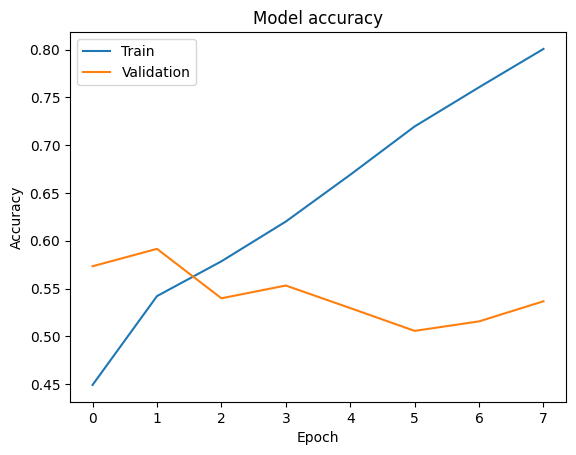

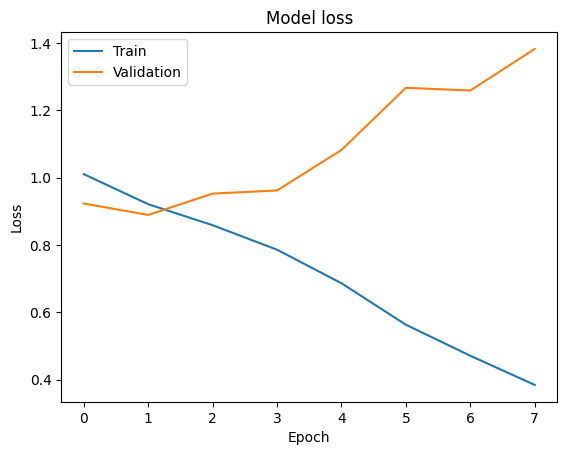

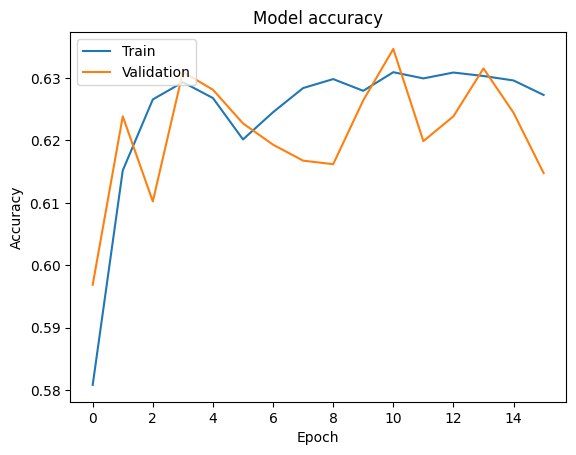

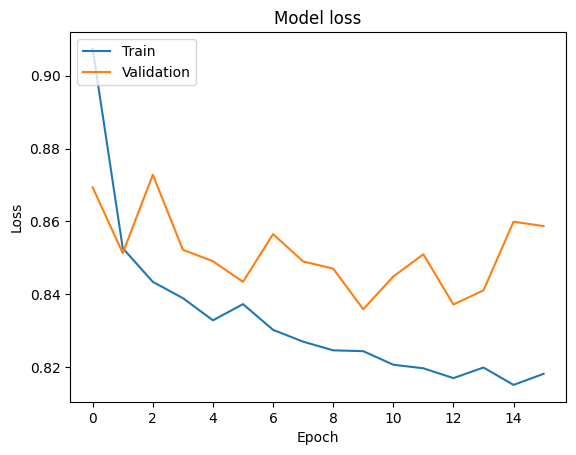

In [27]:
plot_history(history1)
plot_history(history2)